## Training and Evaluating the Model

### Imports

In [1]:
import json
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import minimize
from scipy.stats import poisson
from sklearn.svm import SVR
from sklearn.base import BaseEstimator
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor,
    RandomForestClassifier,
    RandomForestRegressor,
)
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import PoissonRegressor, LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    mean_absolute_error,
    r2_score,
    root_mean_squared_error,
    mean_squared_error
)


/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Setup imports path


In [2]:
import sys
import os

from dotenv import find_dotenv, load_dotenv
backend_dir = os.path.dirname(find_dotenv())
sys.path.insert(0, backend_dir)
print(backend_dir)

/Users/loughlindavidson/Documents/development/EPL_project/EPL_ML_PREDICTOR/backend


### Loading the Data

In [3]:
from app.services.data_processing.data_loader import load_training_data
df = load_training_data(2014)
df.head(3)

,match_id,season,week,day,date,time,home_team_id,away_team_id,home_goals,away_goals,...,referee,match_report,notes,home_team,away_team,home_team_fullname,away_team_fullname,Score,FTHG,FTAG
0,1,2014-2015,1,Sat,2014-08-16,12:45:00,2,27,1,2,...,Mike Dean,Match Report,None,Manchester Utd,Swansea City,Manchester United,Swansea City,1-2,1,2
1,2,2014-2015,1,Sat,2014-08-16,15:00:00,21,26,0,1,...,Anthony Taylor,Match Report,None,Stoke City,Aston Villa,Stoke City,Aston Villa,0-1,0,1
2,3,2014-2015,1,Sat,2014-08-16,15:00:00,10,25,2,2,...,Mike Dean,Match Report,None,Leicester City,Everton,Leicester City,Everton,2-2,2,2


### Data Cleaning

In [4]:
from app.services.data_processing.data_loader import clean_data

df = clean_data(df)
df.head(3)

,match_id,season,week,day,date,time,home_team_id,away_team_id,home_goals,away_goals,...,referee,match_report,notes,home_team,away_team,home_team_fullname,away_team_fullname,Score,FTHG,FTAG
0,1,2014-2015,1,Sat,2014-08-16,12:45:00,2,27,1,2,...,Mike Dean,Match Report,None,Manchester Utd,Swansea City,Manchester United,Swansea City,1-2,1,2
1,2,2014-2015,1,Sat,2014-08-16,15:00:00,21,26,0,1,...,Anthony Taylor,Match Report,None,Stoke City,Aston Villa,Stoke City,Aston Villa,0-1,0,1
2,3,2014-2015,1,Sat,2014-08-16,15:00:00,10,25,2,2,...,Mike Dean,Match Report,None,Leicester City,Everton,Leicester City,Everton,2-2,2,2


### Preprocess data

In [5]:
from app.services.models.preprocess import preprocess_data
from app.services.data_processing.feature_engineering import add_elo_ratings
from app.services.models.config import FEATURES, LABELS

df = preprocess_data(df, test_data=False)

X = df[FEATURES]
y = df[LABELS]

print(FEATURES)

/Users/loughlindavidson/Documents/development/EPL_project/EPL_ML_PREDICTOR/backend/app/services/data_processing/feature_engineering.py:130: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_df = pd.concat(rolling_dfs, ignore_index=False)


H2H features sample:
        date     season       home_team     away_team  h2h_avg_goals_h  \
0 2014-08-16  2014-2015  Manchester Utd  Swansea City              1.5   
1 2014-08-16  2014-2015      Stoke City   Aston Villa              1.5   
2 2014-08-16  2014-2015  Leicester City       Everton              1.5   
3 2014-08-16  2014-2015             QPR     Hull City              1.5   
4 2014-08-16  2014-2015        West Ham     Tottenham              1.5   

   h2h_avg_goals_a  
0              1.5  
1              1.5  
2              1.5  
3              1.5  
4              1.5  
H2H_home_goals range: 0.00 - 6.00
H2H_away_goals range: 0.00 - 8.00
['home_team_encoded', 'away_team_encoded', 'week', 'hour', 'day_code', 'venue_code', 'season_encoded', 'ppg_rolling_h', 'ppg_rolling_a', 'pos_last_season_h', 'pos_last_season_a', 'elo_h', 'elo_a', 'h2h_avg_goals_h', 'h2h_avg_goals_a', 'gf_rolling_h', 'ga_rolling_h', 'sh_rolling_h', 'sot_rolling_h', 'sot_percent_rolling_h', 'g_per_sh_rolli

### Training Split

In [6]:
# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

from sklearn.preprocessing import StandardScaler
from app.services.models.save_load import save_scaler

# Scale your features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
save_scaler(scaler)


## Model Selection and Evaluation

In [7]:
from app.services.utils.superbru_points_calculator import get_superbru_points
# Initialize a DataFrame to store results
results_df = pd.DataFrame()

def evaluate_model_performance(y_true, y_pred, model_name):
    y_true = y_true.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)

    # Calculate metrics
    mae_home = mean_absolute_error(y_true["FTHG"], y_pred["FTHG"])
    mae_away = mean_absolute_error(y_true["FTAG"], y_pred["FTAG"])
    r2_home = r2_score(y_true["FTHG"], y_pred["FTHG"])
    r2_away = r2_score(y_true["FTAG"], y_pred["FTAG"])
    rmse_home = root_mean_squared_error(y_true["FTHG"], y_pred["FTHG"])
    rmse_away = root_mean_squared_error(y_true["FTAG"], y_pred["FTAG"])
    mae_total = (mae_home + mae_away) / 2
    rmse_total = (rmse_home + rmse_away) / 2

    exact_matches = np.sum((y_true["FTHG"] == y_pred["FTHG"]) & (y_true["FTAG"] == y_pred["FTAG"]))
    exact_match_percentage = 100 * exact_matches / len(y_true)
    goal_diff_true = y_true["FTHG"] - y_true["FTAG"]
    goal_diff_pred = y_pred["FTHG"] - y_pred["FTAG"]
    goal_diff_accuracy = np.mean(np.sign(goal_diff_true) == np.sign(goal_diff_pred))

    true_result = np.select(
        [y_true["FTHG"] > y_true["FTAG"], y_true["FTHG"] < y_true["FTAG"]],
        choicelist=["W", "L"],
        default="D",
    )
    pred_result = np.select(
        [y_pred["FTHG"] > y_pred["FTAG"], y_pred["FTHG"] < y_pred["FTAG"]],
        choicelist=["W", "L"],
        default="D",
    )
    correct_results_percentage = 100 * np.sum(pred_result == true_result) / pred_result.shape[0]
    superbru_points = get_superbru_points(
        pd.DataFrame({
            "FTHG": y_true["FTHG"],
            "FTAG": y_true["FTAG"],
            "PredFTHG": y_pred["FTHG"],
            "PredFTAG": y_pred["FTAG"],
            "Result": true_result,
            "PredResult": pred_result,
        })
    )

    # Store results
    result = {
        "Model": model_name,
        "MAE_Home": mae_home,
        "MAE_Away": mae_away,
        "MAE_Total": mae_total,
        "RMSE_Home": rmse_home,
        "RMSE_Away": rmse_away,
        "RMSE_Total": rmse_total,
        "R2_Home": r2_home,
        "R2_Away": r2_away,
        "Exact_Match_%": exact_match_percentage,
        "Goal_Diff_Accuracy": goal_diff_accuracy,
        "Correct_Result_%": correct_results_percentage,
        "Superbru_Points": superbru_points,
    }
    return result

In [8]:
class MedianPredictor(BaseEstimator):
    """
    A custom scikit-learn compatible estimator that predicts the median values of targets.
    Designed for multi-output regression, predicting FTHG and FTAG based on training data medians.
    """
    def __init__(self):
        self.median = None

    def fit(self, X, y):
        self.median = y.median()
        return self

    def predict(self, X):
        n_samples = X.shape[0] if isinstance(X, np.ndarray) else len(X)
        y_pred = np.array([self.median] * n_samples)
        return y_pred

In [9]:
class DixonColesPredictor(BaseEstimator):
    """
    A scikit-learn compatible estimator for the Dixon-Coles model, predicting football match scores
    using a Poisson distribution with correlation adjustment.

    Parameters:
    - target_names: List of target variable names (default: ['FTHG', 'FTAG']).
    - team_col: Column name for team identifiers (default: 'team').
    """
    def __init__(self, target_names=["FTHG", "FTAG"], team_col="team"):
        self.target_names = target_names
        self.team_col = team_col
        self.attack_params = {}  # Team-specific attack strengths
        self.defense_params = {}  # Team-specific defense strengths
        self.home_advantage = 0.0  # Home advantage parameter
        self.theta = 0.0  # Correlation parameter
        self.teams = None  # Unique teams in the dataset

    def _poisson_pmf(self, home_goals, lambda_H, away_goals, lambda_A):
        """Calculate the Poisson PMF with correlation adjustment."""
        prob_home = poisson.pmf(home_goals, lambda_H)
        prob_away = poisson.pmf(away_goals, lambda_A)
        return prob_home * prob_away * np.exp(self.theta * min(home_goals, away_goals))

    def _dixon_coles_likelihood(self, params, data):
        """Compute the negative log-likelihood for the Dixon-Coles model."""
        n_teams = len(self.teams)
        attack = params[:n_teams]
        defense = params[n_teams:2*n_teams]
        self.home_advantage = params[-2]
        self.theta = params[-1]

        log_likelihood = 0
        for index, row in data.iterrows():
            home_team = row["home_team_encoded"]
            away_team = row["away_team_encoded"]
            h = row["FTHG"]
            a = row["FTAG"]

            home_idx = self.teams.get_loc(home_team)
            away_idx = self.teams.get_loc(away_team)

            lambda_H = np.exp(attack[home_idx] + defense[away_idx] + self.home_advantage)
            lambda_A = np.exp(attack[away_idx] + defense[home_idx])

            log_likelihood += np.log(self._poisson_pmf(h, lambda_H, a, lambda_A))

        return -log_likelihood

    def fit(self, X, y):
        """
        Fit the Dixon-Coles model by optimizing team-specific parameters and correlation.

        Parameters:
        - X: Training feature data (DataFrame with 'home_team_encoded' and 'away_team_encoded' columns).
        - y: Training target data (DataFrame with 'FTHG' and 'FTAG' columns).

        Returns:
        - self: Fitted estimator.
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame")
        if not all(col in X.columns for col in ["home_team_encoded", "away_team_encoded"]):
            raise ValueError("X must contain 'home_team_encoded' and 'away_team_encoded' columns")
        if not all(col in y.columns for col in self.target_names):
            raise ValueError(f"y must contain columns: {self.target_names}")

        # Combine X and y for likelihood computation
        data = pd.concat([X[["home_team_encoded", "away_team_encoded"]], y], axis=1)
        
        # Get unique teams
        self.teams = pd.Index(np.unique(np.concatenate([X["home_team_encoded"].values, X["away_team_encoded"].values])))
        n_teams = len(self.teams)

        # Initialize parameters: attack and defense for each team, home advantage, theta
        initial_params = [1.0] * (2 * n_teams) + [0.1, 0.0]  # attack, defense, home_advantage, theta

        # Optimize parameters
        result = minimize(
            self._dixon_coles_likelihood,
            initial_params,
            args=(data,),
            method="Nelder-Mead",
            options={'maxiter': 1000}
        )

        # Store optimized parameters
        attack = result.x[:n_teams]
        defense = result.x[n_teams:2*n_teams]
        self.home_advantage = result.x[-2]
        self.theta = result.x[-1]

        for i, team in enumerate(self.teams):
            self.attack_params[team] = attack[i]
            self.defense_params[team] = defense[i]

        return self

    def predict(self, X):
        """
        Predict FTHG and FTAG using the fitted Dixon-Coles model.

        Parameters:
        - X: Input feature data (DataFrame with 'home_team' and 'away_team' columns).

        Returns:
        - y_pred: Predicted values (DataFrame with 'FTHG' and 'FTAG' columns).
        """
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X must be a pandas DataFrame with 'home_team' and 'away_team' columns")
        if not all(col in X.columns for col in ["home_team", "away_team"]):
            raise ValueError("X must contain 'home_team' and 'away_team' columns")

        y_pred = []
        for _, row in X.iterrows():
            home_team = row["home_team_encoded"]
            away_team = row["away_team_encoded"]

            if home_team not in self.teams or away_team not in self.teams:
                # Default to average lambda if team is unseen
                lambda_H = np.exp(1.0 + self.home_advantage)
                lambda_A = np.exp(1.0)
            else:
                home_idx = self.teams.get_loc(home_team)
                away_idx = self.teams.get_loc(away_team)
                lambda_H = np.exp(self.attack_params[home_team] + self.defense_params[away_team] + self.home_advantage)
                lambda_A = np.exp(self.attack_params[away_team] + self.defense_params[home_team])

            # Predict as the expected value (rounded for discrete goals)
            pred_home = np.round(lambda_H).astype(int)
            pred_away = np.round(lambda_A).astype(int)
            y_pred.append([pred_home, pred_away])

        return pd.DataFrame(y_pred, columns=self.target_names)

### Model Comparison

In [10]:
# Define models with param grids for tuning (where applicable)
models = {
    "Linear Regression": {
        "model": LinearRegression(),  # Supports multi-output
        "param_grid": {"fit_intercept": [True, False]},
        "multi_output": True,
    },
    "Lasso Regression": {
        "model": Lasso(),
        "param_grid": {"alpha": [0.01, 0.1, 1.0, 10.0]},
        "multi_output": True,
    },
    "Ridge Regression": {
        "model": Ridge(),
        "param_grid": {"alpha": [0.01, 0.1, 1.0, 10.0]},
        "multi_output": True,
    },
    "Gradient Boosting": {
        "model": MultiOutputRegressor(GradientBoostingRegressor(random_state=42)),
        "param_grid": {
            "estimator__n_estimators": [100, 300],
            "estimator__learning_rate": [0.01, 0.1],
            "estimator__max_depth": [3, 5]
        },
        "multi_output": True
    },
    "SVM": {
        "model_home": SVR(),
        "model_away": SVR(),
        "param_grid": {"C": [0.1, 1, 10], "kernel": ["rbf", "linear"]},
        "multi_output": False  # Does not support multi-output; keep separate
    },
    "Poisson Regression": {
        "model_home": PoissonRegressor(),
        "model_away": PoissonRegressor(),
        "param_grid": {"alpha": [0.01, 0.1, 1.0], "max_iter": [100, 300]},
        "multi_output": False  # Single-target only
    },
    "Random Forest": {
        "model": RandomForestRegressor(random_state=42),  # Supports multi-output
        "param_grid": {
            "n_estimators": [50, 100, 200],  # Added more trees
            "max_depth": [5, 10, 20],  # Reduced max depth
            "min_samples_split": [5, 10]  # Increased to reduce overfitting
        },
        "multi_output": True
    },
    "Median Predictor": {  # Custom; assuming joint, no tuning
        "model": MedianPredictor(),
        "multi_output": True
    },
}

In [11]:
results_df = pd.DataFrame()
losses = {name: {"train_mse": None, "val_mse": None} for name in models.keys()} # store losses
feature_importances = {name: {} for name in models.keys()}  # Store importances
models_trained = {}  # Store trained models


for model_name, model_info in models.items():
    print(model_name)
    
    if "param_grid" in model_info:
        if model_info["multi_output"]:
            grid = GridSearchCV(
                estimator=model_info["model"],
                param_grid=model_info["param_grid"],
                cv=3,
                scoring="neg_mean_squared_error",
                n_jobs=-1
            )
            grid.fit(X_train_scaled, y_train)
            best_model = grid.best_estimator_
            models_trained[model_name] = best_model  # Store the model
            y_pred = np.round(best_model.predict(X_val_scaled)).astype(int)
            y_pred = pd.DataFrame({"FTHG": y_pred[:, 0], "FTAG": y_pred[:, 1]})
            # Compute MSE
            y_pred_train = np.round(best_model.predict(X_train_scaled)).astype(int)
            y_pred_train = pd.DataFrame({"FTHG": y_pred_train[:, 0], "FTAG": y_pred_train[:, 1]})
            losses[model_name]["train_mse"] = mean_squared_error(y_train, y_pred_train, multioutput="raw_values").mean()
            losses[model_name]["val_mse"] = mean_squared_error(y_val, y_pred, multioutput="raw_values").mean()

            # Feature importances
            if model_name in ["Linear Regression", "Lasso Regression", "Ridge Regression"]:
                feature_importances[model_name]["FTHG"] = np.abs(best_model.coef_[0])
                feature_importances[model_name]["FTAG"] = np.abs(best_model.coef_[1])                                                                 
            elif model_name in ["Random Forest"]:
                feature_importances[model_name]["FTHG"] = np.abs(best_model.feature_importances_)
                feature_importances[model_name]["FTAG"] = np.abs(best_model.feature_importances_)
            elif model_name == "Gradient Boosting":
                feature_importances[model_name]["FTHG"] = best_model.estimators_[0].feature_importances_
                feature_importances[model_name]["FTAG"] = best_model.estimators_[1].feature_importances_
        else:
            grid_home = GridSearchCV(
                estimator=model_info["model_home"],
                param_grid=model_info["param_grid"],
                cv=3,
                scoring="neg_mean_squared_error",
                n_jobs=-1
            )
            grid_home.fit(X_train_scaled, y_train["FTHG"])
            best_model_home = grid_home.best_estimator_
            
            grid_away = GridSearchCV(
                estimator=model_info["model_away"],
                param_grid=model_info["param_grid"],
                cv=3,
                scoring="neg_mean_squared_error",
                n_jobs=-1
            )
            grid_away.fit(X_train_scaled, y_train["FTAG"])
            best_model_away = grid_away.best_estimator_
            
            models_trained[model_name] = {"model_home": best_model_home, "model_away": best_model_away}  # Store both models
            y_pred_home = np.round(best_model_home.predict(X_val_scaled)).astype(int)
            y_pred_away = np.round(best_model_away.predict(X_val_scaled)).astype(int)
            y_pred = pd.DataFrame({"FTHG": y_pred_home, "FTAG": y_pred_away})
            # Compute MSE
            y_pred_train_home = np.round(best_model_home.predict(X_train_scaled)).astype(int)
            y_pred_train_away = np.round(best_model_away.predict(X_train_scaled)).astype(int)
            y_pred_train = pd.DataFrame({"FTHG": y_pred_train_home, "FTAG": y_pred_train_away})
            losses[model_name]["train_mse"] = mean_squared_error(y_train, y_pred_train, multioutput="raw_values").mean()
            losses[model_name]["val_mse"] = mean_squared_error(y_val, y_pred, multioutput="raw_values").mean()

            # Feature importances
            if model_name == "Poisson Regression":
                feature_importances[model_name]["FTHG"] = np.abs(best_model_home.coef_)
                feature_importances[model_name]["FTAG"] = np.abs(best_model_away.coef_)
    else:
        model_info["model"].fit(X_train_scaled, y_train)
        models_trained[model_name] = model_info["model"]  # Store the model
        y_pred = np.round(model_info["model"].predict(X_val_scaled)).astype(int)
        y_pred = pd.DataFrame({"FTHG": y_pred[:, 0], "FTAG": y_pred[:, 1]})
        y_pred_train = np.round(model_info["model"].predict(X_train_scaled)).astype(int)
        y_pred_train = pd.DataFrame({"FTHG": y_pred_train[:, 0], "FTAG": y_pred_train[:, 1]})
        losses[model_name]["train_mse"] = mean_squared_error(y_train, y_pred_train, multioutput="raw_values").mean()
        losses[model_name]["val_mse"] = mean_squared_error(y_val, y_pred, multioutput="raw_values").mean()
        # No feature importances for Median Predictor (assumed custom)
    
    result = evaluate_model_performance(y_val, y_pred, model_name)
    results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)

Linear Regression


/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/panda

Lasso Regression


/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Ridge Regression


/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Gradient Boosting


/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


SVM
Poisson Regression
Random Forest
Median Predictor


### Training vs Validation Loss

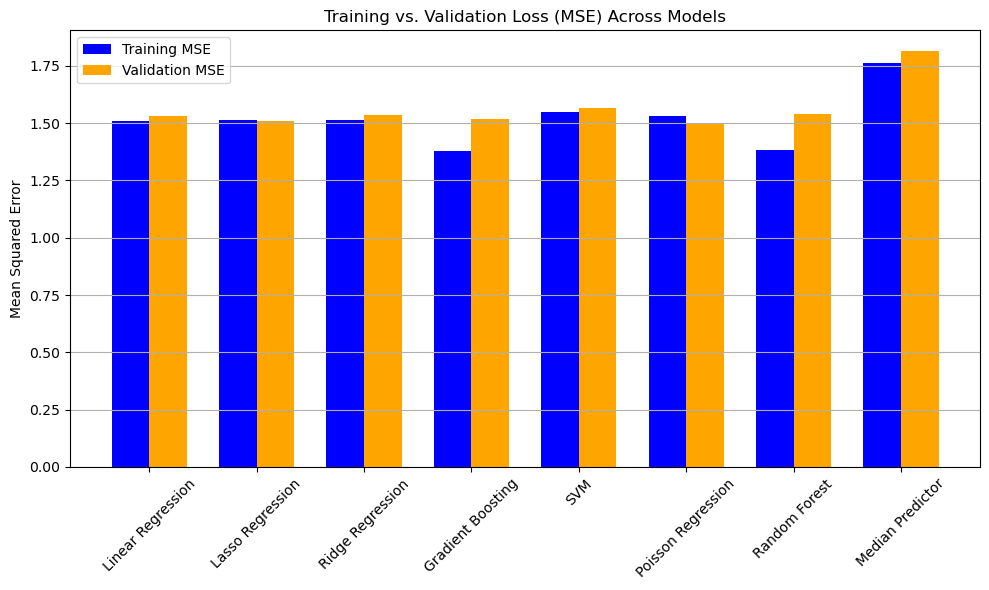

Linear Regression - Train MSE: 1.511, Val MSE: 1.532
Lasso Regression - Train MSE: 1.513, Val MSE: 1.508
Ridge Regression - Train MSE: 1.513, Val MSE: 1.536
Gradient Boosting - Train MSE: 1.380, Val MSE: 1.518
SVM - Train MSE: 1.550, Val MSE: 1.565
Poisson Regression - Train MSE: 1.531, Val MSE: 1.501
Random Forest - Train MSE: 1.384, Val MSE: 1.538
Median Predictor - Train MSE: 1.764, Val MSE: 1.814


In [12]:
# Prepare data for plotting
model_names = list(losses.keys())
train_mses = [losses[name]["train_mse"] for name in model_names]
val_mses = [losses[name]["val_mse"] for name in model_names]

# Plot
plt.figure(figsize=(10, 6))
x = np.arange(len(model_names))
width = 0.35
plt.bar(x - width/2, train_mses, width, label="Training MSE", color="blue")
plt.bar(x + width/2, val_mses, width, label="Validation MSE", color="orange")
plt.xticks(x, model_names, rotation=45)
plt.title("Training vs. Validation Loss (MSE) Across Models")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()

# Print losses
for name in model_names:
    print(f"{name} - Train MSE: {losses[name]['train_mse']:.3f}, Val MSE: {losses[name]['val_mse']:.3f}")

#### Feature Importance

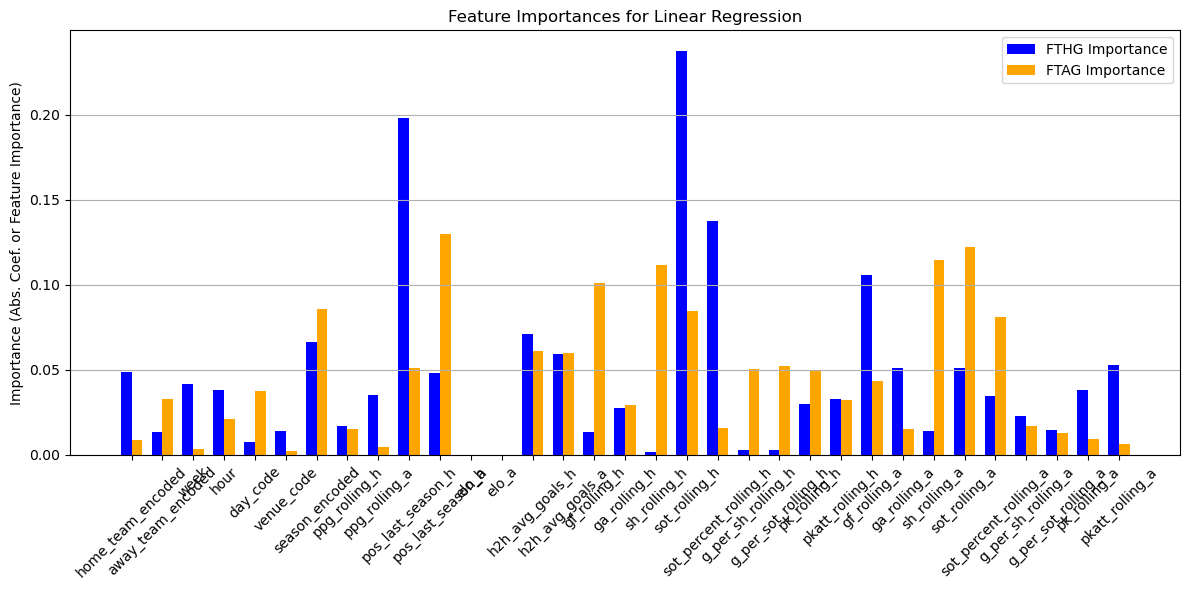

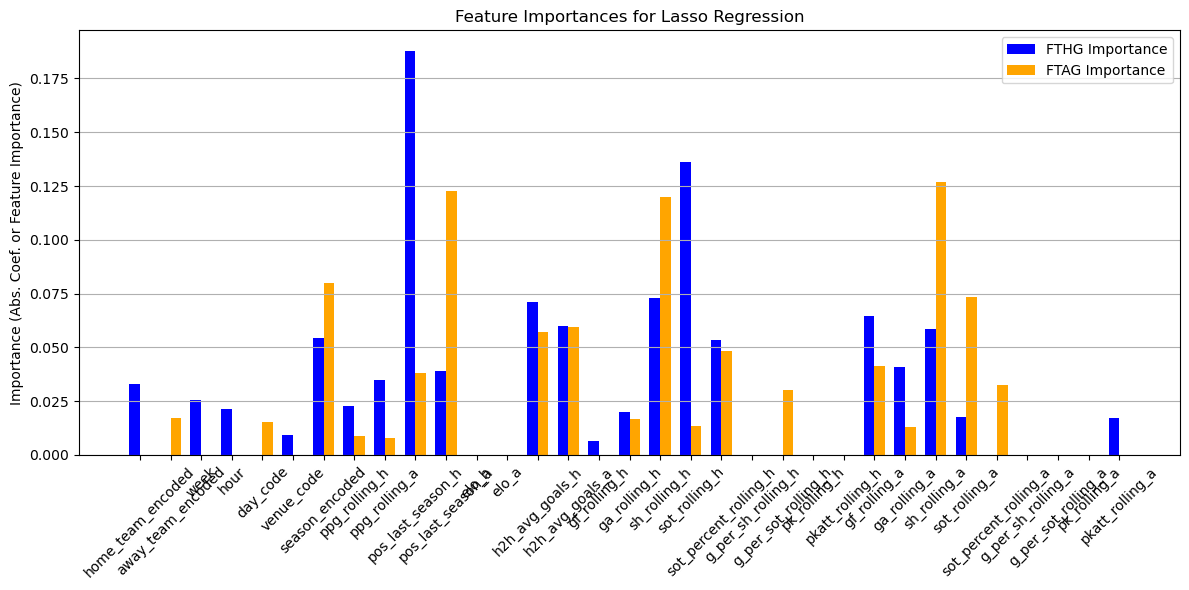

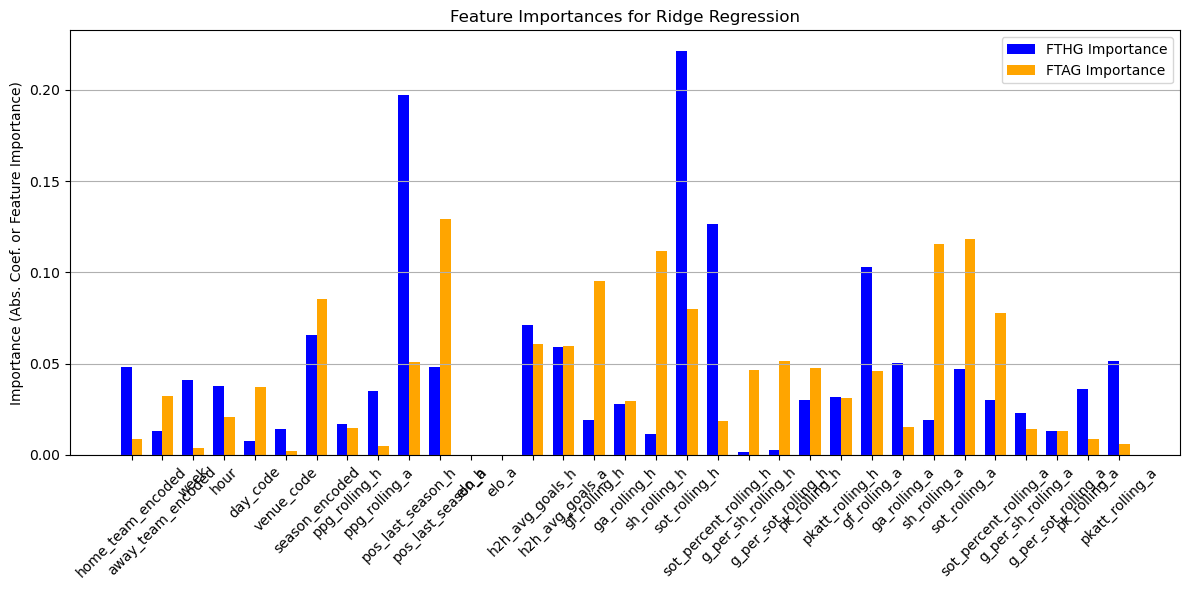

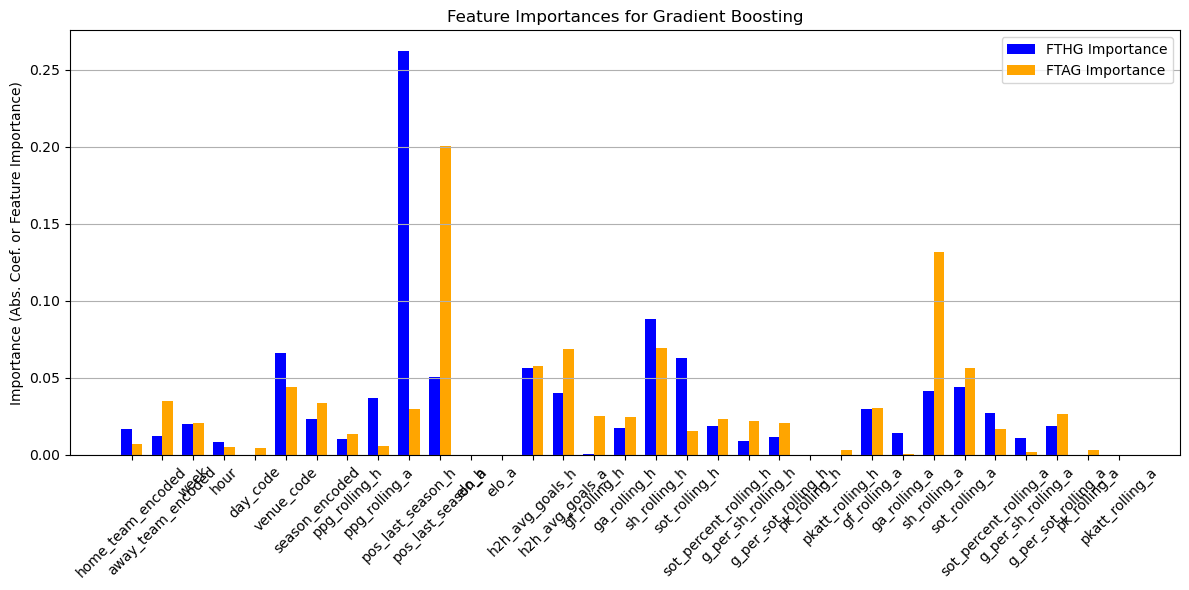

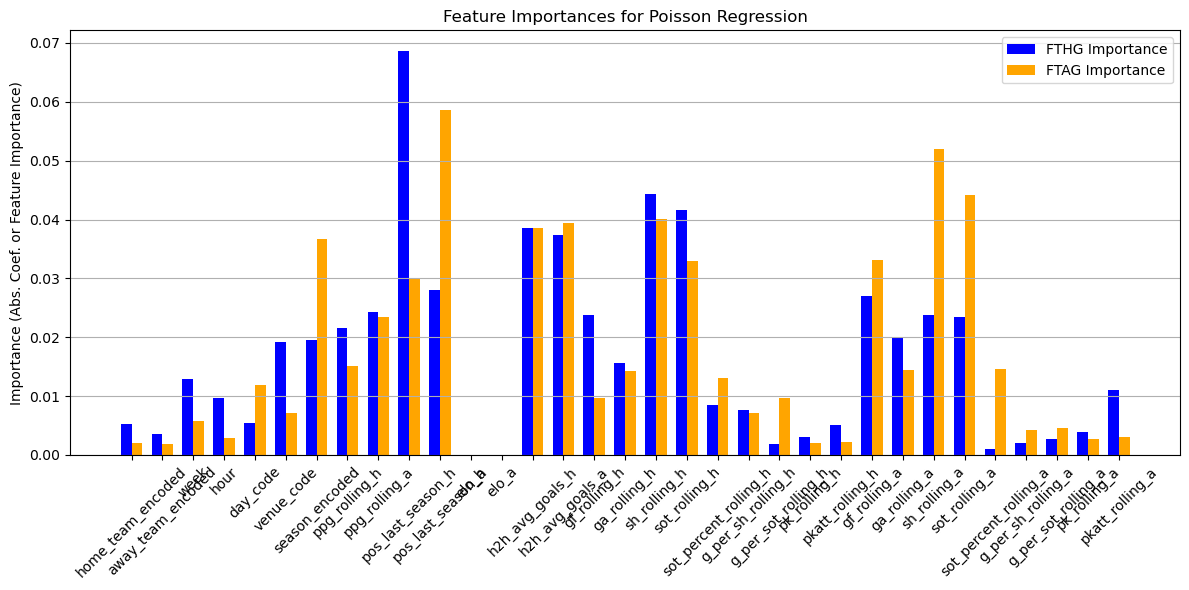

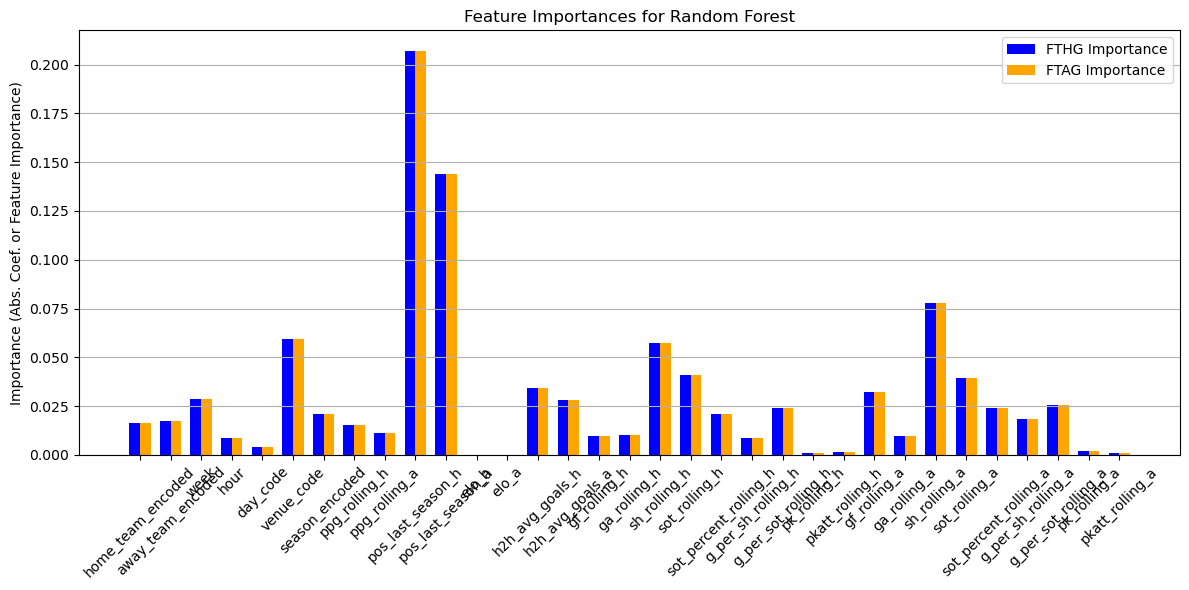

In [13]:
# Plot feature importances
feature_names = X_train.columns

for model_name in results_df["Model"]:
    if model_name in feature_importances and feature_importances[model_name]:
        plt.figure(figsize=(12, 6))
        x = np.arange(len(feature_names))
        width = 0.35
        plt.bar(x - width/2, feature_importances[model_name]["FTHG"], width, label="FTHG Importance", color="blue")
        plt.bar(x + width/2, feature_importances[model_name]["FTAG"], width, label="FTAG Importance", color="orange")
        plt.xticks(x, feature_names, rotation=45)
        plt.title(f"Feature Importances for {model_name}")
        plt.ylabel("Importance (Abs. Coef. or Feature Importance)")
        plt.legend()
        plt.grid(True, axis="y")
        plt.tight_layout()
        plt.show()

#### Evaluate Neural Network

Reloading Tuner from nn_tuning_dir/untitled_project/tuner0.json
Epoch 1/200


/Users/loughlindavidson/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - loss: 3.7792 - val_loss: 2.3768
Epoch 2/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 2.2999 - val_loss: 1.8656
Epoch 3/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 459us/step - loss: 1.9203 - val_loss: 1.7499
Epoch 4/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - loss: 1.8224 - val_loss: 1.7050
Epoch 5/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 458us/step - loss: 1.6924 - val_loss: 1.6734
Epoch 6/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 475us/step - loss: 1.6292 - val_loss: 1.6514
Epoch 7/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 1.6843 - val_loss: 1.6347
Epoch 8/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 1.6209 - val_loss: 1.6235
Epoch 9/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 439us/step - loss: 1.6787 - val_loss: 1.6143
Epoch 10/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 1.6094 - val_loss: 1.6091
Epoch 11/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - loss: 1.5956 - val_loss: 1.6060
Epoch 12/200
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step

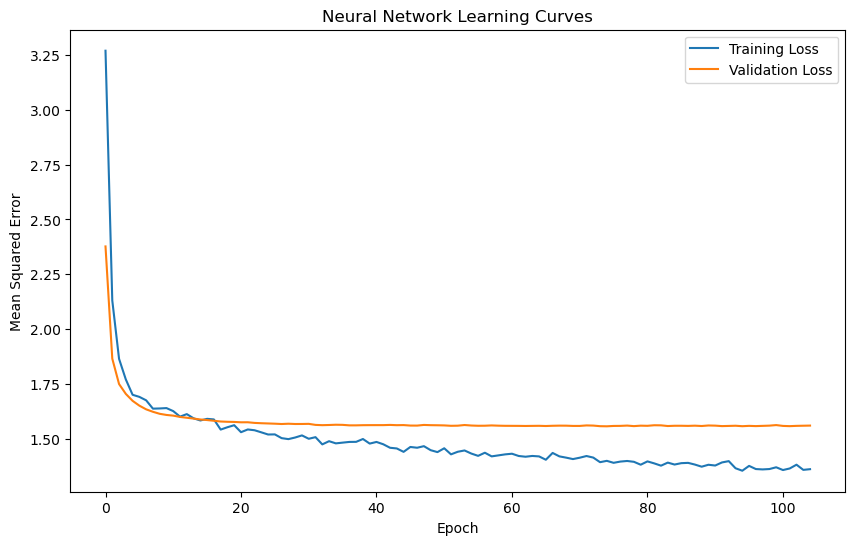

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step


In [14]:
def build_nn_model(hp):
    model = Sequential([
        Input(shape=(X_train_scaled.shape[1],)),
        Dense(hp.Int("units1", min_value=32, max_value=128, step=32), activation="relu"),
        Dropout(hp.Float("dropout1", min_value=0.2, max_value=0.5, step=0.1)),
        Dense(hp.Int("units2", min_value=32, max_value=128, step=32), activation="relu"),
        Dropout(hp.Float("dropout2", min_value=0.2, max_value=0.5, step=0.1)),
        Dense(y_train.shape[1]),
    ])
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", [0.0001, 0.001, 0.01, 0.1])),
        loss="mean_squared_error"
    )
    return model

tuner = RandomSearch(
    build_nn_model,
    objective="val_loss",
    max_trials=5,
    executions_per_trial=1,
    directory="nn_tuning_dir",
)
early_stopping = EarlyStopping(monitor="val_loss", patience=30, restore_best_weights=True)
tuner.search(
    X_train_scaled,
    y_train,
    epochs=200,  # Increased from 100
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)
best_nn_model = tuner.get_best_models(num_models=1)[0]

# Fit best model again to capture history for plotting
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model_for_history = build_nn_model(best_hps)
history = model_for_history.fit(
    X_train_scaled,
    y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Neural Network Learning Curves")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

# Evaluate on validation set
y_pred_nn = np.round(best_nn_model.predict(X_val_scaled)).astype(int)
y_pred_nn = pd.DataFrame({"FTHG": y_pred_nn[:, 0], "FTAG": y_pred_nn[:, 1]})
result_nn = evaluate_model_performance(y_val, y_pred_nn, "Neural Network")
results_df = pd.concat([results_df, pd.DataFrame([result_nn])], ignore_index=True)

#### Evaluate Dixon-Coles

In [15]:
# dc_model = DixonColesPredictor(target_names=["FTHG", "FTAG"])
# dc_model.fit(X_train, y_train)
# y_pred_dc = dc_model.predict(X_val_scaled)
# result_dc = evaluate_model_performance(y_val, y_pred_dc, "Dixon Coles")
# results_df = pd.concat([results_df, pd.DataFrame([result_dc])], ignore_index=True)

#### Display Results

                Model  MAE_Home  MAE_Away  MAE_Total  RMSE_Home  RMSE_Away  \
5  Poisson Regression     0.964     0.837      0.901      1.294      1.152   
1    Lasso Regression     0.979     0.839      0.909      1.307      1.144   
2    Ridge Regression     0.986     0.850      0.918      1.315      1.158   
0   Linear Regression     0.982     0.853      0.917      1.309      1.162   
3   Gradient Boosting     0.971     0.853      0.912      1.308      1.152   
6       Random Forest     0.971     0.863      0.917      1.313      1.163   
4                 SVM     0.966     0.846      0.906      1.326      1.171   
8      Neural Network     0.999     0.858      0.928      1.380      1.164   
7    Median Predictor     1.036     0.880      0.958      1.454      1.231   

   RMSE_Total  R2_Home  R2_Away  Exact_Match_%  Goal_Diff_Accuracy  \
5       1.223    0.051    0.080         11.579               0.476   
1       1.225    0.033    0.093         10.658               0.483   
2       1

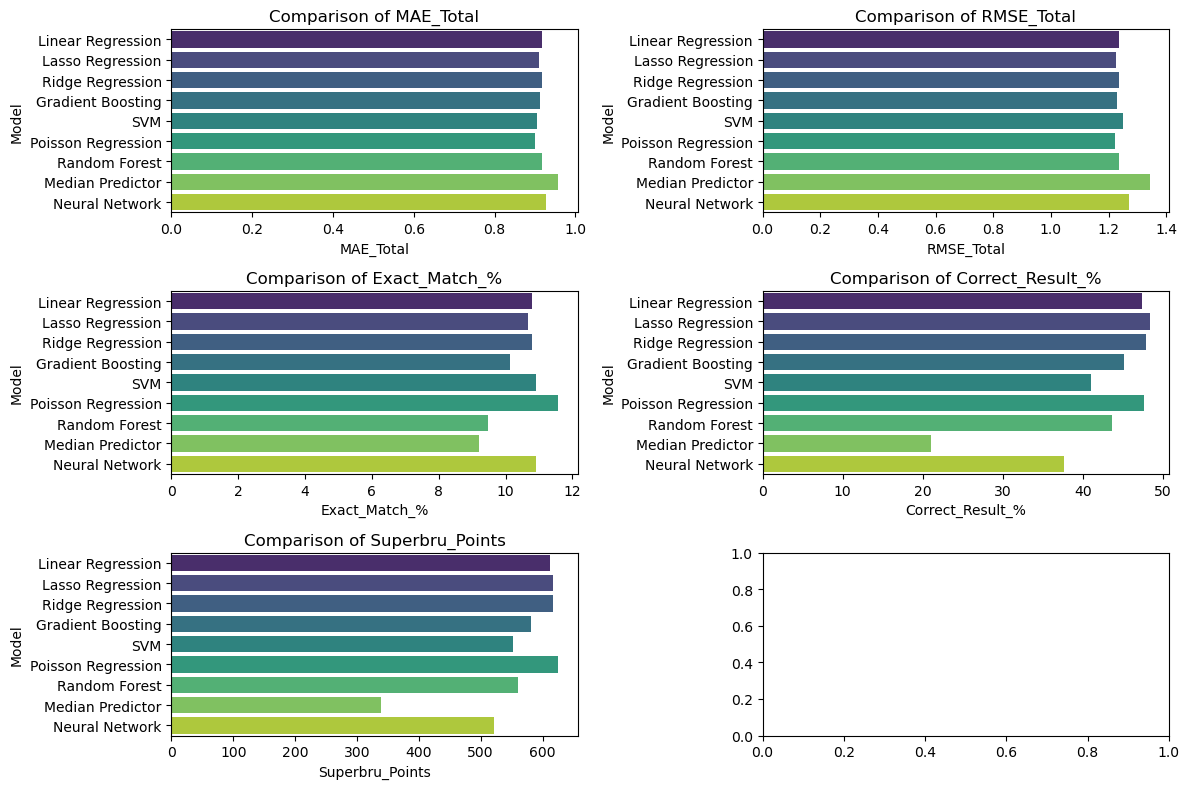

In [16]:
print(results_df.sort_values(by="Superbru_Points", ascending=False).round(3))

# Bar chart for key metrics
metrics_to_plot = ["MAE_Total", "RMSE_Total", "Exact_Match_%", "Correct_Result_%", "Superbru_Points"]
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    sns.barplot(x=metric, y="Model", data=results_df, ax=axes[i], palette="viridis")
    axes[i].set_title(f"Comparison of {metric}")
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel("Model")

plt.tight_layout()
plt.show()

#### Linear Regression Model

#### Support Vector Machines (SVM) for Multi-Output Regression


### Poisson Regression
**Why**: <br>
Goals in football matches can often be modeled as Poisson-distributed, as the number of goals scored in a game is a count of independent scoring events.

**How**: <br>
Use a Generalized Linear Model (GLM) with a Poisson distribution, where the targets (FTHG and FTAG) are assumed to follow a Poisson distribution with means that depend on the input features.

**Implementation**: <br>
You can use libraries like statsmodels or scikit-learn for Poisson regression. This can directly model integer outputs and is interpretable.


In [17]:
def plot_confusion_matrices(y_true, y_pred, target_names=["FTHG", "FTAG"], figsize=(12, 5), 
                           cmap="Blues", save_path=None):
    """
    Plot confusion matrices for each target variable in a multi-output classification problem.
    
    Parameters:
    - y_true: DataFrame or array-like, true labels (e.g., y_val with columns FTHG, FTAG)
    - y_pred: DataFrame or array-like, predicted labels (e.g., y_pred with columns FTHG, FTAG)
    - target_names: List of target variable names (default: ["FTHG", "FTAG"])
    - figsize: Tuple of (width, height) for the figure size
    - cmap: Colormap for the heatmap (default: "Blues")
    - save_path: Path to save the plot (optional, if None, plot is displayed)
    
    Returns:
    - None (displays or saves the plot)
    """
    # Convert inputs to DataFrame if they aren't already
    if not isinstance(y_true, pd.DataFrame):
        y_true = pd.DataFrame(y_true, columns=target_names)
    if not isinstance(y_pred, pd.DataFrame):
        y_pred = pd.DataFrame(y_pred, columns=target_names)
    
    # Determine unique classes (assuming integer goals, e.g., 0 to max_goals)
    max_goals = max(y_true.max().max(), y_pred.max().max())
    classes = np.arange(0, max_goals + 1)
    
    # Create subplots: one for each target
    fig, axes = plt.subplots(1, len(target_names), figsize=figsize)
    if len(target_names) == 1:
        axes = [axes]  # Ensure axes is iterable for single target
    
    # Plot confusion matrix for each target
    for i, target in enumerate(target_names):
        # Compute confusion matrix
        cm = confusion_matrix(y_true[target], y_pred[target], labels=classes)
        
        # Plot heatmap
        sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, ax=axes[i], 
                    xticklabels=classes, yticklabels=classes)
        axes[i].set_title(f"Confusion Matrix: {target}")
        axes[i].set_xlabel("Predicted")
        axes[i].set_ylabel("True")
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    
    # Save or display the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        plt.close()
    else:
        plt.show()

### Save Best Model

In [18]:
from app.core.paths import SAVED_MODELS_DIRECTORY
from app.services.models.save_load import save_model

save_model(best_nn_model, "nn_model.pkl", SAVED_MODELS_DIRECTORY)

In [19]:
import joblib
import json
import pandas as pd
import numpy as np

def select_and_save_best_model(losses, models_trained, save_path="best_model"):
    """
    Select the best model based on validation MSE and save it along with metadata.
    
    Parameters:
    - losses: Dictionary with model names as keys and {"train_mse": float, "val_mse": float} as values
    - models_trained: Dictionary with model names as keys and trained model objects as values
    - feature_importances: Dictionary with model names as keys and feature importance dicts as values
    - save_path: Base path for saving model and metadata (default: "best_model")
    
    Returns:
    - best_model: The trained model with lowest val_mse
    - best_model_info: Dictionary with model name, losses, and feature importances
    """
    # Find model with lowest validation MSE
    best_model_name = min(losses, key=lambda x: losses[x]["val_mse"])
    best_model = models_trained[best_model_name]
    
    # Prepare metadata
    best_model_info = {
        "model_name": best_model_name,
        "train_mse": losses[best_model_name]["train_mse"],
        "val_mse": losses[best_model_name]["val_mse"],
    }
    
    # Save the model
    joblib.dump(best_model, f"{save_path}.joblib")

    print(f"Best model: {best_model_name} (val_mse: {losses[best_model_name]['val_mse']:.4f})")
    print(best_model_info)
    # Save metadata as JSON
    with open(f"{save_path}_metadata.json", "w") as f:
        json.dump(best_model_info, f, indent=4)
    
    print(f"Saved model to {save_path}.joblib and metadata to {save_path}_metadata.json")
    
    return best_model, best_model_info

best_model, best_model_info = select_and_save_best_model(
    losses, models_trained, feature_importances, save_path=f"{SAVED_MODELS_DIRECTORY}/best_model"
)

TypeError: select_and_save_best_model() got multiple values for argument 'save_path'

### Loading the Saved Model

In [ ]:
import joblib
import json

# Load model
best_model = joblib.load("best_model.joblib")

# Load metadata
with open("best_model_metadata.json", "r") as f:
    best_model_info = json.load(f)

# Make predictions
y_pred = np.round(best_model.predict(X_test_scaled)).astype(int)
if isinstance(best_model, dict):  # Handle single-output models
    y_pred = pd.DataFrame({
        "FTHG": np.round(best_model["model_home"].predict(X_test_scaled)).astype(int),
        "FTAG": np.round(best_model["model_away"].predict(X_test_scaled)).astype(int)
    })
else:
    y_pred = pd.DataFrame({"FTHG": y_pred[:, 0], "FTAG": y_pred[:, 1]})